In [38]:
import json
import os
from dataclasses import dataclass
from functools import reduce

import numpy as np
import tables
from dataforge import Meta, Name
from phd.thunderstorm.dwyer_feedback import histogrammed_reverse_data_v2
from phd.utils.convertor_tools import direction_to_degree
from phd.utils.path_tools import find_by_meta, get_attrs_values
from scipy.optimize import curve_fit
from tables import File, Group, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d

In [13]:
mpl.rcParams.update(
    {'font.family': 'sans-serif',
     'font.size': 16,
     'axes.labelsize': 16,
     'xtick.labelsize': 16,
     'ytick.labelsize': 16,
     'legend.fontsize': 16})

image_path = '/home/zelenyy/npm/scientific-papers/Russian-Phd-LaTeX-Dissertation/Dissertation/images/'

# Радиальное распределеине новых затравочных

In [5]:
def get_radial(data, step):
    if data.size != 0:
        max_ = data["radius"].max() + step
    else:
        max_ = 100
    bins = np.arange(0, max_, step)
    hist, _ = np.histogram(data["radius"], bins)
    return hist, bins

In [6]:
path = "/mnt/storage2/phd/data/thunderstorm/dwyer2003/"
result = []
step = 10
for i in range(0,6):
    path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
    with tables.open_file(path_hdf5) as h5file:
        for group in h5file.root:
            table_positron = h5file.get_node(group, "positron")
            table_gamma = h5file.get_node(group, "gamma")
            number = table_gamma.attrs["values_macros_number"]
            height = table_gamma.attrs["values_gdml_height"]
            cell = table_gamma.attrs["values_gdml_cellHeight"]
            field = table_gamma.attrs["values_gdml_fieldValueZ"]
            data = table_positron.read()
            data_pos = get_radial(data, step)
            data = table_gamma.read()
            data_gamma = get_radial(data,step)
            result.append([height, cell, field, number,  data_gamma, data_pos])

fields = np.unique(np.fromiter(map(lambda x: x[2], result), dtype="d"))

In [18]:
def sum_hist(hists : list):
    i = 0
    for indx, item in enumerate(hists):
        hist, _ = item
        if hist.size > hists[i][0].size:
            i = indx
    hist, bins = hists.pop(i)
    for item in hists:
        i = item[0].size
        hist[:i] += item[0]
    return hist, bins

In [32]:
sum_result = []
for field in fields:
    temp_pos = []
    temp_gamma = []
    number = 0
    for item in result:
        if field == item[2]:
            temp_pos.append(item[-1])
            temp_gamma.append(item[-2])
            number += item[-3]
            cell = item[1]
    sum_result.append([field, number, sum_hist(temp_gamma), sum_hist(temp_pos), cell])

In [53]:
def plot(sum_result,save_path, particle="gamma"):
    i = 2 if particle == "gamma" else 3
    plt.figure(figsize=(7,7))
    for item in sum_result:
        if np.all(item[2][0] == 0):
            continue
        hist, bins = item[i]
        n = item[1]
        field = item[0]
        cell = item[-1]
        plt.step(bins[:-1], hist/n, label="{:.1f} кВ/см, {:d} м".format(1e+4*field, cell))
        plt.xlim(-10, 800)
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.xlabel("Расстояние от центра лавины, м")
        plt.ylabel("Число частиц")
        plt.savefig(os.path.join(save_path, "radial_{}.pdf".format(particle)), fmt="pdf", transparent=True)

In [3]:
rfdm_path = os.path.join(image_path, "thunderstorm/rdfm")

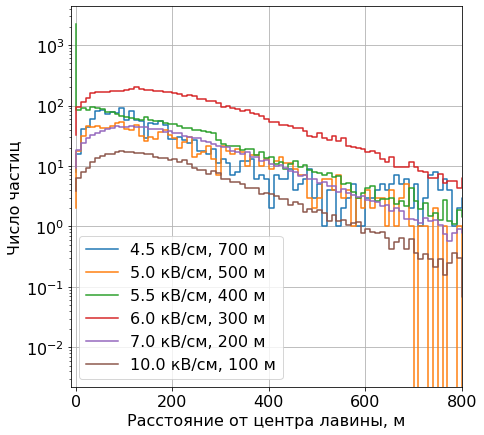

In [55]:
plot(sum_result, rfdm_path, "gamma")

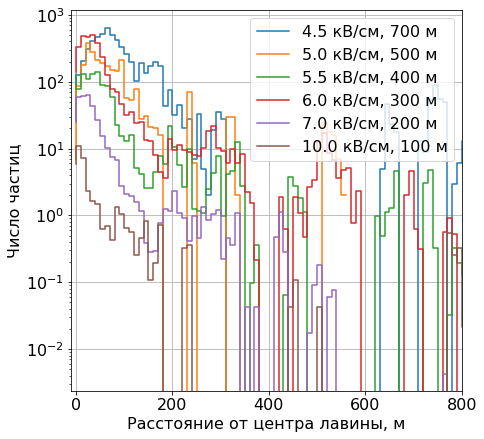

In [56]:
plot(sum_result, rfdm_path, "positron")

# Вертикальное распределеине новых затравочных


In [14]:
rfdm_path = os.path.join(image_path, "thunderstorm/rdfm")
path = "/home/zelenyy/backup_data/data/thunderstorm/dwyer2003/"
path_reverse = "/home/zelenyy/backup_data/data/thunderstorm/reversed_1/grid_v2.hdf5"

In [15]:
fields = []
for i in range(0,6):
    path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
    with tables.open_file(path_hdf5) as h5file:
        for group in h5file.root:
            table_gamma = h5file.get_node(group, "gamma")
            field = table_gamma.attrs["values_gdml_fieldValueZ"]
            fields.append(field)
fields = np.unique(fields)

In [16]:
def get_field_data(field, path, particle="gamma"):
    cell = None
    number = 0
    result = []
    numbers_ = []
    for i in range(0,6):
        path_hdf5 = os.path.join(path, f"diff_{i}.hdf5")
        with tables.open_file(path_hdf5) as h5file:
            for group in h5file.root:
                table = h5file.get_node(group, particle)
                field_ = table.attrs["values_gdml_fieldValueZ"]
                if field == field_:
                    n = table.attrs["values_macros_number"]
                    number  += n
                    numbers_.append(n)
                    cell = table.attrs["values_gdml_cellHeight"]
                    data = table.read()
                    result.append(data)

    if field==5.5e-4:
        data = result[0]
        return field, cell, numbers_[0], data

    data = result[0].copy()
    if len(result) > 1:
        i = data.size
        n = reduce(lambda acc, x: acc + x, map(lambda x: x.size, result))
        data.resize(n)
        for item in result[1:]:
            j = item.size
            data[i : i+j] = item[:]
            i = i + j
    return field, cell, number, data

In [17]:
def calc_vertical(path, path_reverse, field, particle="gamma"):
    field, cell, number, data = get_field_data( field, path, particle)
    print( field, cell, number)
    indx = np.logical_and(data["energy"] > 3, data["z"] < cell/2)
    print(data.size, np.sum(indx), 100*np.sum(indx)/data.size)

    reverseHist = histogrammed_reverse_data_v2(path_reverse, field)
    bins_z = np.arange(0,cell/2 + 1,10)
    bins = (bins_z, np.arange(-5,96,10), np.arange(0.05, 3.01, 0.05), )
    histHeight , _  = np.histogramdd([data["z"], np.rad2deg(data["theta"]), data["energy"], ], bins=bins)
    result = []
    for item in histHeight:
        temp = np.sum(item*reverseHist.probability)
        result.append(temp)
    result = np.array(result)/ number
    return field, cell, result, bins_z

In [27]:
# import numpy as np
#
# def feedback(distrubution : np.ndarray, max_iteration: int) -> np.ndarray:
#     distrubution = distrubution[::-1]
#     for i in range(max_iteration):
#         temp = np.zeros(distrubution.size)
#         for indx, it in enumerate(distrubution):
#             if indx ==0:
#                 temp = it*distrubution
#             else:
#                 temp[indx:] += it*distrubution[:-indx]
#         distrubution = temp
#     return distrubution

def plot_iteration(path, path_reverse,save_path, field, max_iteration, particle="gamma"):
    field, cell, result, bins_z = calc_vertical(path, path_reverse, field, particle)
    plt.step(bins_z[:-1], result, label = "0")
    gamma = result[::-1]
    for i in range(max_iteration):
        temp = np.zeros(gamma.size)
        for indx, it in enumerate(gamma):
            if indx ==0:
                temp = it*gamma
            else:
                temp[indx:] += it*gamma[:-indx]
        plt.step(bins_z[:-1], temp[::-1], label=str(i+1))
        plt.yscale("log")
        gamma = temp
    # print(np.sum(temp[::-1]*x)/np.sum(temp))
    plt.title("{:.1f} кВ/см, {:d} м".format(1e4*field, cell))
    plt.xlabel("Высота, м")
    plt.ylabel("Число затравочных частиц")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "vertical_{}_{:.1f}.pdf".format(particle, 1e4*field)).replace(".", "_", 1), fmt="pdf", transparent=True)

In [22]:
# plot_iteration(path, path_reverse, fields[0], 1, "gamma")
# plot_iteration(path, path_reverse, fields[0], 1, "positron")
# plot_iteration(path, path_reverse, fields[1], 2, "gamma")
# plot_iteration(path, path_reverse,rfdm_path, fields[1], 2, "positron")

0.0005 500 1
1288 32 2.484472049689441


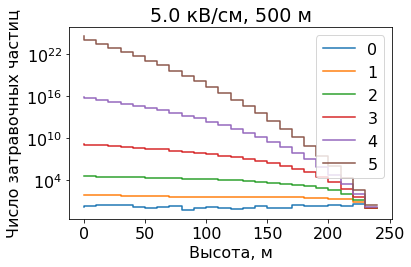

In [28]:
plot_iteration(path, path_reverse,rfdm_path, fields[2], 5, "gamma")

0.0005 500 1
2525 18 0.7128712871287128


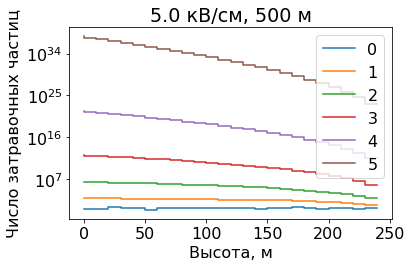

In [29]:
plot_iteration(path, path_reverse,rfdm_path, fields[2], 5, "positron")

0.00055 400 30
113057 44837 39.65875620262346


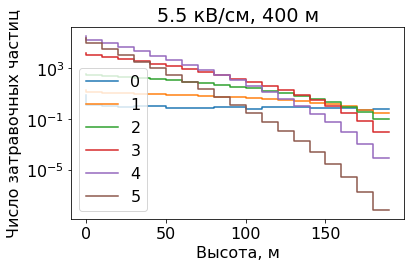

In [30]:
plot_iteration(path, path_reverse,rfdm_path, fields[3], 5, "gamma")

0.00055 400 30
5463 2171 39.74006955885045


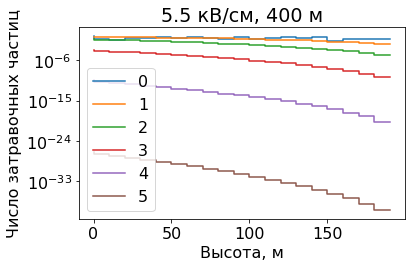

In [31]:
plot_iteration(path, path_reverse,rfdm_path, fields[3], 5, "positron")

0.0006 300 32
43359 173 0.3989944417537305


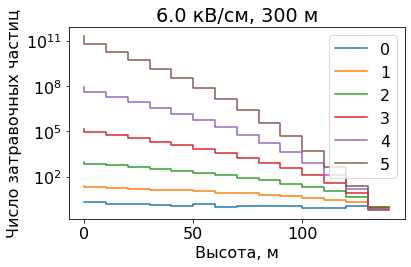

In [32]:
plot_iteration(path, path_reverse,rfdm_path, fields[4], 5, "gamma")

0.0006 300 32
25692 160 0.6227619492449011


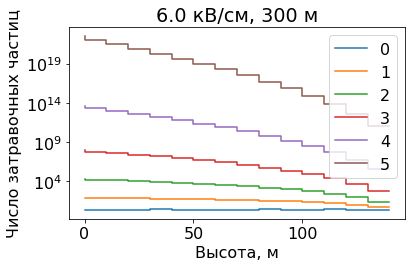

In [33]:
plot_iteration(path, path_reverse,rfdm_path, fields[4], 5, "positron")

0.0007 200 232
77961 93 0.11929041443798823


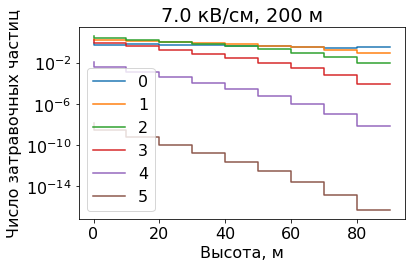

In [34]:
plot_iteration(path, path_reverse,rfdm_path, fields[5], 5, "gamma")

0.0007 200 232
19374 75 0.387116754413131


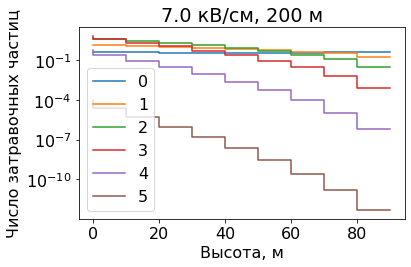

In [35]:
plot_iteration(path, path_reverse,rfdm_path, fields[5], 5, "positron")

0.001 100 232
27667 16 0.05783062854664402


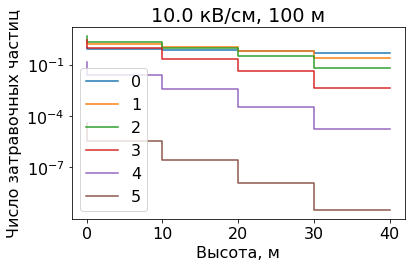

In [36]:
plot_iteration(path, path_reverse,rfdm_path, fields[6], 5, "gamma")

0.001 100 232
2118 3 0.141643059490085


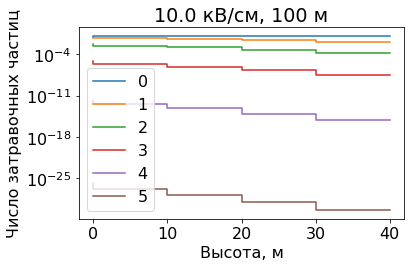

In [37]:
plot_iteration(path, path_reverse,rfdm_path, fields[6], 5, "positron")

In [11]:
fields_rev = list(get_attrs_values(path_reverse, "values_gdml_fieldValueZ"))

In [129]:
fields_rev[-3]

0.0006000000000000001

In [130]:
fields[4]


0.0006

# From AYSS-2018

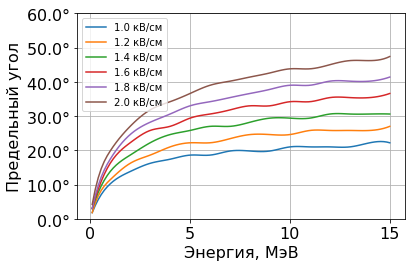

In [40]:
path = "/mnt/storage2/phd/data/thunderstorm/AYSS_2019_PLASMA_2020/"
path_rev = os.path.join(path, "electron_reversal")
template = 'ElecRevField{}Density0.526.txt'
field = [100, 120, 140, 160, 180, 200]
fieldcm = np.asarray(field)/100
for f in field:
    path1 = os.path.join(path_rev, template.format(f))
    data = np.loadtxt(path1)
    fun = interp1d(data[:,0], data[:,1], kind=3)
    x = np.linspace(data[:,0].min(), data[:,0].max(), 100)
    plt.plot(x, 90 - fun(x), label='{} кВ/см'.format(f/100))

# plt.title('Electron (and Positron) reversal condition')
plt.xlabel('Энергия, МэВ')
plt.ylabel('Предельный угол')
plt.ylim(ymin=0, ymax=60)
yticks, _ = plt.yticks()
plt.yticks(yticks, [r'${}\degree$'.format(t) for t in yticks]);
plt.legend(loc=0, fontsize=10);
plt.tight_layout();
plt.grid(True)
plt.savefig(os.path.join(image_path, "thunderstorm", 'ayss_2018_rev.pdf'),fmt="pdf", transparent=True);


In [41]:
gammaGain = np.loadtxt(os.path.join(path, "gamma.cpp"))
positronGain =  np.loadtxt(os.path.join(path, "vrode_pozitrony.cpp"))

In [42]:
def error_gain(gain, gamma=False):
    if gamma:
        number_of_primary_electron = np.array([100000, 50000, 20000, 10000])
    else:
        number_of_primary_electron = np.array([50000, 10000,10000, 500, 500, 100])
    return gain*((gain+1)/number_of_primary_electron/gain)**0.5

In [43]:
gammaField = np.array([100, 140, 180, 220])
gammaGain =np.array([0.002, 0.012, 0.035, 0.08])

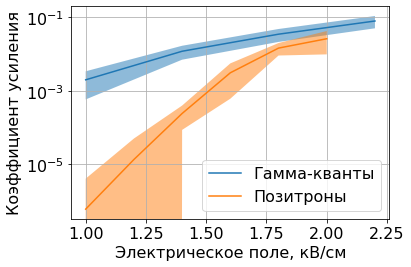

In [45]:
plt.plot(gammaField/100, gammaGain, label='Гамма-кванты')
dy = error_gain(gammaGain, True)*10
y = gammaGain
plt.fill_between(gammaField/100,y-dy, y+dy, alpha=0.5 )
plt.plot(positronGain[:,0]/100, positronGain[:,1],label='Позитроны')
dy = error_gain(positronGain[:,1])
y = positronGain[:,1]
plt.fill_between(positronGain[:,0]/100,y-dy, y+dy, alpha=0.5 )
plt.yscale('log')
plt.legend()
plt.xlabel('Электрическое поле, кВ/см')
plt.ylabel('Коэффициент усиления')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(image_path, "thunderstorm", 'ayss_2018_fb.pdf'),fmt="pdf", transparent=True)